In [31]:
# from IPython.display import YouTubeVideo
# # A video on what you can do with Software defined radio. The B200 is a high-end SDR which is capable to much more than the rtl-sdr. 
# # however, most of the stuff shown in the video could be done with the rtl-sdr as well. 
# YouTubeVideo('cygDXeZaiOM')
import pyModeS as pms
import threading
import time
import sys
import queue 

In [32]:
from rtlsdr import RtlSdr

In [33]:
from __future__ import division
import numpy as np, matplotlib.pyplot as plt
from numpy import *
from numpy.fft import *
from matplotlib.pyplot import *
import threading,time

%matplotlib inline

In [ ]:
# sdr.close()

In [34]:
# your code here:
sdr = RtlSdr()

In [ ]:
print(sdr.valid_gains_db)

[0.0, 0.9, 1.4, 2.7, 3.7, 7.7, 8.7, 12.5, 14.4, 15.7, 16.6, 19.7, 20.7, 22.9, 25.4, 28.0, 29.7, 32.8, 33.8, 36.4, 37.2, 38.6, 40.2, 42.1, 43.4, 43.9, 44.5, 48.0, 49.6]


In [ ]:
gain = sdr.valid_gains_db[29//2 + 2]


In [191]:

sdr.close()

sdr.set_sample_rate(2000000)    # sampling rate
sdr.set_center_freq(1090e6)

gain = sdr.valid_gains_db[len(sdr.valid_gains_db)//2 + 2]


N_samples = 20480000*2 # approximately 20 seconds
y = sdr.read_samples(N_samples)


samples = y[0:8000]

sdr.close()

In [ ]:
sample = y

np.save('sample1.npy',abs(sample))

In [ ]:
np.save('adsb.npy',abs(y))

In [72]:
from scipy.io import wavfile


In [130]:
# TODO: Implement reading file, a major bug exist
# fs, data = wavfile.read("../adsb_20190311_191728Z_1090000kHz_RF.wav")
# I, Q = data[:, 0], data[:, 1]
# A = np.sqrt(I*I + Q*Q)
# y = A

C:\Users\nguye\AppData\Local\Temp\ipykernel_14192\2375271807.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, data = wavfile.read("../adsb_20190311_191728Z_1090000kHz_RF.wav")
C:\Users\nguye\AppData\Local\Temp\ipykernel_14192\2375271807.py:3: RuntimeWarning: invalid value encountered in sqrt
  A = np.sqrt(I*I + Q*Q)


Text(0.5, 0, 'samples')

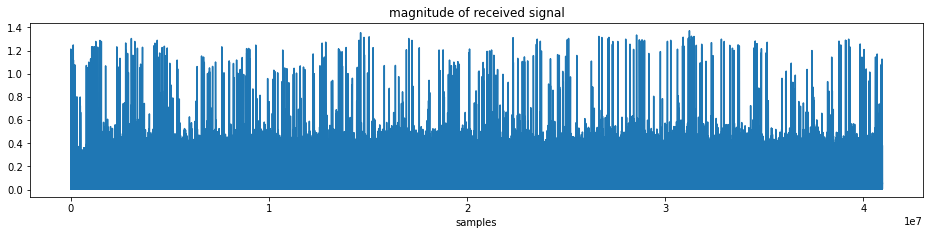

In [192]:
width, height = figaspect(0.2)
fig = figure(figsize=(width, height))
plot(abs(y))
title('magnitude of received signal')
xlabel('samples')


In [132]:
# y = np.array(abs(data[:, 0]), dtype=float)
max(y)


1530.0

In [117]:
y

array([1158., 1998., 2307., ...,  326.,  170.,  900.])

In [193]:
# data loading code 

# y = np.load('../adsb.npy')
fs = 2000000;
y = abs(y) / max(abs(y))

In [103]:
nonzero(y == max(abs( y)))[0]

array([0, 1], dtype=int64)

<StemContainer object of 3 artists>

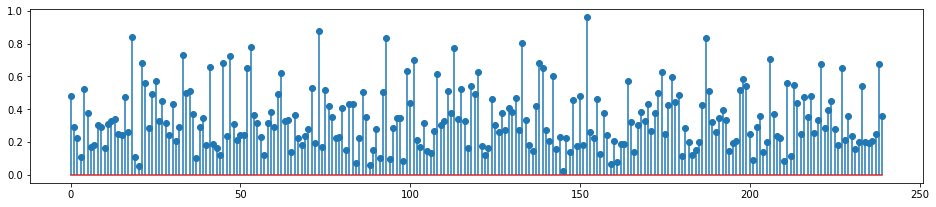

In [154]:
idx = 0
chunk_length = 112*2+16

y_chunk = y[idx: idx + chunk_length] 

width, height = figaspect(0.2)
fig = figure(figsize=(width,height))
plt.stem( abs(y_chunk ) )

<StemContainer object of 3 artists>

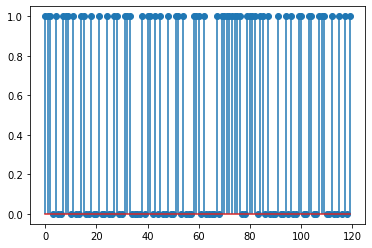

In [155]:
decoded = np.array([1 if y_chunk[2*i+1]<y_chunk[2*i] else 0 for i in range(len(y_chunk)//2)])

plt.stem(decoded)

In [39]:
bit_str = ""
for bit in decoded[16:len(decoded)]:
  bit_str += str(bit)
bit_str

# symbols = "#ABCDEFGHIJKLMNOPQRSTUVWXYZ#####_###############0123456789######"
# code_str = ""
# for p in range(8):
#     c = int(bits_str[8 + 6*p:8 + 6*(p + 1)], 2)
#     code_str += symbols[c]
# print("Aircraft Identification:", code_str.replace('#', ''))


'10001000111110001110111110010100001101100001101011100001110010111010000100011101100010110100101101101000'

In [40]:
tesS = "00100011100101010111000111110111110001111000"
pms.tell(tesS)

             Message: 00100011100101010111000111110111110001111000 
        ICAO address: 57D52B 
     Downlink Format: 0 


In [41]:
pms.tell(bit_str)

             Message: 10001000111110001110111110010100001101100001101011100001110010111010000100011101100010110100101101101000 
        ICAO address: None 
     Downlink Format: 2 


In [25]:
df = int(bit_str[0:5], 2)
df

17

In [ ]:
def get_address(msg):
  symbols = "#ABCDEFGHIJKLMNOPQRSTUVWXYZ#####_###############0123456789######"
  code_str = ""
  for p in range(8):
      c = int(msg[8 + 6*p:8 + 6*(p + 1)], 2)
      code_str += symbols[c]
  print("Identification:", code_str.replace('#', ''))


In [ ]:
decoded[0:15]

array([0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0])

In [194]:
# your code here
y_median = np.median(y)
y_mad = np.median(abs(y - y_median))
y_std = 1.4826*y_mad

print(y_median)
print(y_mad)
print(y_std)

0.053222886528739716
0.020599273916392907
0.030540483508444124


In [ ]:
import scipy.stats

In [195]:
N=5
threshfn = lambda N: y_median + N*y_std

def threshold(a, threshmin=None, threshmax=None, newval=0):
    a = ma.array(a, copy=True)
    mask = np.zeros(a.shape, dtype=bool)
    if threshmin is not None:
        mask |= (a < threshmin).filled(False)

    if threshmax is not None:
        mask |= (a > threshmax).filled(False)

    a[mask] = newval
    return a

print(threshfn(2), threshfn(3), threshfn(4), threshfn(5), threshfn(6))

thresh = threshfn(N)

y_thresh = threshold(y, threshmin = thresh, newval = 0)
idx_sig = np.nonzero(y_thresh)[0]

0.11430385354562797 0.14484433705407207 0.1753848205625162 0.20592530407096032 0.23646578757940445


In [196]:
idx_sig.shape

(107077,)

In [165]:
def detectPreambleXcorr(chunk, corrthresh):
    cmean = np.mean(chunk)
    preamble = array([1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0]) # - .25
    pmean = np.mean(preamble)
    
    pdenom = np.sqrt(abs((preamble - pmean).dot(preamble - pmean)))
    cdenom = np.sqrt(abs((chunk - cmean).dot(chunk - cmean)))
    
    xcorr = 0
    for n in range(len(chunk)):
        xcorr += (chunk[n] - cmean)*(preamble[n] - pmean)/(cdenom*pdenom)
        
    return (xcorr > corrthresh)

In [46]:
idx_corr = []
for i in idx_sig:
    idx_corr += [detectPreambleXcorr(y[i:i+16],.85)]

In [ ]:
idx_corr = np.array(idx_corr)

Text(0.5, 0, 'The Received message')

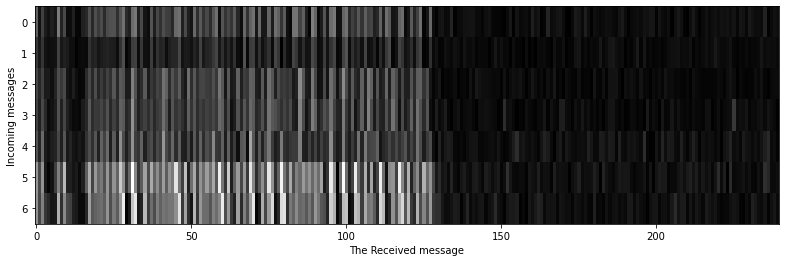

In [47]:
msgs = []
for i in range(len(idx_sig)):
    if(idx_corr[i]):
        idx = idx_sig[i]
        msgs += [y[idx:idx+(16+112*2)]]

width, height = figaspect(0.3)
fig = figure(figsize=(width,height))
plt.imshow(msgs, aspect='auto', cmap="gray")
plt.ylabel("Incoming messages")
plt.xlabel("The Received message")

In [197]:
def detectPreamble(y):

    idx_preamble = []
    N=5
    y_median = np.median(y)
    y_mad = np.median(abs(y - y_median))
    y_std = 1.4826*y_mad
    threshfn = lambda N: y_median + N*y_std
    thresh = threshfn(N)
    y_thresh = threshold(y, threshmin = thresh, newval = 0)
    
    idx_sig = np.nonzero(y_thresh)[0]
    y = y_thresh
    for i in idx_sig:
        if i + 16 >= len(y):
            break
        
        chunk = y[i:i+16]
        cmean = np.mean(chunk)
        if (chunk[0]>cmean and chunk[2]>cmean and chunk[7]>cmean and chunk[1]<=cmean and chunk[9]>cmean 
            and chunk[3]<=cmean  and chunk[4]<=cmean  and (chunk[5]<=cmean or chunk[6]<=cmean) and (chunk[8]<=cmean or chunk[6]<=cmean)
            and (chunk[14]<=cmean and chunk[13]<=cmean)):
            idx_preamble += [i]

    return np.array(idx_preamble)

In [198]:
idx_preamble = detectPreamble(y)

In [199]:
idx_preamble.shape

(178,)

Text(0.5, 0, 'The Received message')

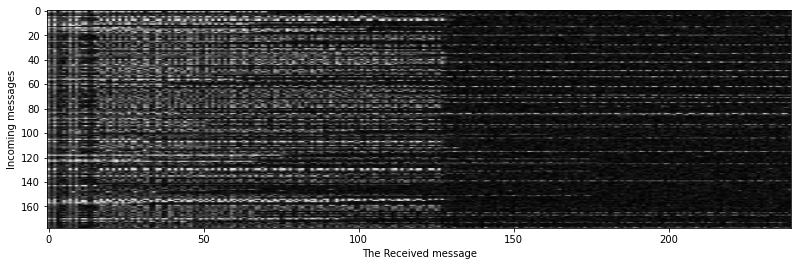

In [200]:
# your code here:
msgs = []
for idx in idx_preamble:
    msgs += [y[idx:idx+(16+112*2)]]


width, height = figaspect(0.3)
fig = figure(figsize=(width,height))
plt.imshow(msgs, aspect='auto', cmap="gray")
plt.ylabel("Incoming messages")
plt.xlabel("The Received message")

In [201]:
def bool2Hex(lst):
    tmp =  ''.join(['1' if x else '0' for x in lst])
    return hex(int(tmp,2))[2:]

In [202]:
msgs = np.array(msgs)
count = 0
for n in r_[0:msgs.shape[0]] :
    bits = msgs[n,16::2] > msgs[n,17::2]
    msg = bool2Hex(bits)
    crc = pms.crc(msg)
    if (crc==0): # long
        count = count + 1
        print(count,"Valid Message Found, DF",pms.df(msg),"ICAO:",pms.adsb.icao(msg),"typecode:",pms.adsb.typecode(msg),"MSG:",msg)
    else: # short or nothing
        crc = pms.crc(msg[:14])
        if (crc==0): # short message
            count = count + 1
            print(count,"Valid Message Found",pms.df(msg),"MSG:",msg[:14])

1 )CRC OK, DF 17 ICAO: ac0941 typecode: 29 MSG: 8dac0941ea09d847d13c083c3131
2 )CRC OK, DF 11 MSG: 5dac0941107a73
3 )CRC OK, DF 17 ICAO: abd9b6 typecode: 19 MSG: 8dabd9b699080397d8088727abc2
4 )CRC OK, DF 11 MSG: 5da782e40ac553
5 )CRC OK, DF 17 ICAO: a782e4 typecode: 4 MSG: 8da782e423041331e79ca0443ab0
6 )CRC OK, DF 17 ICAO: a782e4 typecode: 29 MSG: 8da782e4ea040848013c080a99ed
7 )CRC OK, DF 17 ICAO: abf025 typecode: 29 MSG: 8dabf025ea07e844c93c084757b7
8 )CRC OK, DF 11 MSG: 5da782e40ac553
9 )CRC OK, DF 17 ICAO: abf025 typecode: 11 MSG: 8dabf0255819b3cd84ce124e9be7


In [203]:
count

9

In [ ]:
class Plane:
    addr = -1
    flightnum = 'UNKNOWN'
    position = (-1, -1)
    planetype = 0
    velocity = NaN
    ewv = NaN
    nsv = NaN
    lat0 = 0
    lat1 = 0
    lon0 = 0
    lon1 = 0
    time0 = -1
    time1 = -1
    heading = 0

    def __init__(self, addr):
        self.addr = addr
        print("New plane found:", addr)

    def addplanetype(self, planetype):
        self.planetype = planetype

    def addflightnum(self, flightnum):
        self.flightnum = flightnum

    def addposition(self, position):
        self.position = position
    
    def addVel(self, v, ewv = None, nsv = None):
      if(ewv != None):
        self.ewv = ewv
      if(nsv != None):
        self.nsv = nsv 
      self.velocity = v

In [239]:

LONG_MSG_BITS = 112
SHORT_MSG_BITS = 56
LONG_MSG_BYTES = (112//8)


def lenMessage(type):
    if (type == 16 or type == 17 or type == 19 or type == 20 or type == 21):
        return LONG_MSG_BITS
    else:
        return SHORT_MSG_BITS


def NL(rlat):
    # A.1.7.2.d (page 9)
    NZ = 15
    return np.floor(2 * np.pi /
                    (np.arccos(1 - (1 - np.cos(np.pi / (2 * NZ)))
                               / np.cos(np.pi / 180 * abs(rlat)) ** 2)))


def cprN(lat,  isodd):
    nl = NL(lat) - isodd
    if (nl < 1):
        nl = 1
    return nl


def Dlon(lat,  isodd):
    return 360.0 / cprN(lat, isodd)


def cprmod(a, b):
    res = a % b
    if (res < 0):
        res = res + b
    return res


def decodeCPR(plane):
    AirDlat0 = 360.0 / 60
    AirDlat1 = 360.0 / 59

    lat0 = plane.lat0
    lat1 = plane.lat1
    lon0 = plane.lon0
    lon1 = plane.lon1

    j = np.floor(((59*lat0 - 60*lat1) / 131072) + 0.5)

    rlat0 = AirDlat0 * (cprmod(j, 60) + lat0 / 131072)
    rlat1 = AirDlat1 * (cprmod(j, 59) + lat1 / 131072)

    if (rlat0 >= 270):
        rlat0 = rlat0 - 360

    if (rlat1 >= 270):
        rlat1 = rlat1 - 360

    if (NL(rlat0) != NL(rlat1)):
        return

    if (plane.time0 > plane.time1):

        # Use even packet.
        ni = cprN(rlat0, 0)
        m = np.floor((((lon0 * (NL(rlat0)-1)) -
                       (lon1 * NL(rlat0))) / 131072) + 0.5)
        lon = Dlon(rlat0, 0) * (cprmod(m, ni)+lon0/131072)
        lat = rlat0
    else:
        # Use odd packet
        ni = cprN(rlat1, 1)
        m = np.floor((((lon0 * (NL(rlat1)-1)) -
                       (lon1 * NL(rlat1))) / 131072) + 0.5)
        lon = Dlon(rlat1, 1) * (cprmod(m, ni)+lon1/131072)
        lat = rlat1
    if (lon > 180):
        lon = lon - 360

    plane.addposition((lat, lon))

In [248]:
def decodeModesMessage(msg, plane_list, log):
    ais_charset = np.array(
        list("?ABCDEFGHIJKLMNOPQRSTUVWXYZ????? ???????????????0123456789??????"))

    msgtype = msg[0] >> 3
    msgbits = lenMessage(msgtype)
    # ICAO address ( airplane address )
    aa1 = msg[1]
    aa2 = msg[2]
    aa3 = msg[3]

    metype = msg[4] >> 3
    mesub = msg[4] & 7

    if ((msgtype == 16 or msgtype == 17 or msgtype == 18 or msgtype == 19 or msgtype == 20 or msgtype == 21)):
        addr = (aa1 << 16) | (aa2 << 8) | aa3

        if (addr in plane_list):
            plane = plane_list[addr]
        else:
            plane = Plane(addr)
            plane_list[addr] = plane
            print("Found new plane\n Address:: %x" % addr)
            if (len(plane_list) == 1):
                print("Found %d plane" % len(plane_list))

            else:
                print("Found %d planes" % len(plane_list))

        if (metype >= 1 and metype <= 4):
            aircraft_type = metype - 1
            flight_index = np.array([msg[5] >> 2,
                                     ((msg[5] & 3) << 4) | (msg[6] >> 4),
                                     ((msg[6] & 15) << 2) | (msg[7] >> 6),
                                     msg[7] & 63,
                                     msg[8] >> 2,
                                     ((msg[8] & 3) << 4) | (msg[9] >> 4),
                                     ((msg[9] & 15) << 2) | (msg[10] >> 6),
                                     msg[10] & 63])

            flightnum = ais_charset[flight_index]
            print("Plane %x number flight is" % ''.join(flightnum), addr)

            plane.addplanetype(aircraft_type)
            plane.addflightnum("".join(flightnum))
        elif (metype >= 9 and metype <= 18):

            isodd = msg[6] & (1 << 2)
            lat_enc = ((msg[6] & 3) << 15) | (msg[7] << 7) | (msg[8] >> 1)
            lon_enc = ((msg[8] & 1) << 16) | (msg[9] << 8) | msg[10]

            if (isodd):
                plane.lat1 = lat_enc
                plane.lon1 = lon_enc
                plane.time1 = time.time()

                if (plane.time0 == -1):
                    return
            else:
                plane.lat0 = lat_enc
                plane.lon0 = lon_enc
                plane.time0 = time.time()

                if (plane.time1 == -1):
                    return

            if (abs(plane.time0 - plane.time1) <= 10):
                decodeCPR(plane)
                print("Found Position (%f,%f) for plane %x!\n", plane.position[0], plane.position[1], addr)

        elif (metype == 19 and mesub >= 1 and mesub <= 4):
            if (mesub == 1 or mesub == 2):
                ew_dir = (msg[5] & 4) >> 2
                ew_velocity = ((msg[5] & 3) << 8) | msg[6]
                ns_dir = (msg[7] & 0x80) >> 7
                ns_velocity = ((msg[7] & 0x7f) << 3) | ((msg[8] & 0xe0) >> 5)
                vert_rate_source = (msg[8] & 0x10) >> 4
                vert_rate_sign = (msg[8] & 0x8) >> 3
                vert_rate = ((msg[8] & 7) << 6) | ((msg[9] & 0xfc) >> 2)
                velocity = sqrt(ns_velocity*ns_velocity +
                                ew_velocity*ew_velocity)
                if (velocity):
                    ewv = ew_velocity
                    nsv = ns_velocity

                    if (ew_dir):
                        ewv *= -1
                    if (ns_dir):
                        nsv *= -1
                    heading = -arctan2(ewv, nsv)
                    if (heading < 0):
                        heading += 2 * np.pi
                    plane.addVel(velocity, ewv, nsv)
                else:
                    heading = 0
                plane.heading = heading

            if (mesub == 3 or mesub == 4):
                plane.heading = (
                    360 / 128) * (((msg[5] & 3) << 5) | (msg[6] >> 3)) * np.pi / 180

            print("found plane angle %f degree for plane %x!\n" % (plane.heading * 180.0 / np.pi, addr))
        elif metype == 19:
          pass
        # TODO: Some special case go here



In [234]:
msgs
def bit2byte(bits):
    msg = np.zeros(LONG_MSG_BYTES, dtype='int')

    # Pack bits into bytes */
    for i in r_[:LONG_MSG_BITS:8]:
        for j in r_[:8]:
            msg[i // 8] = msg[i // 8] + (int(bits[i+j]) << (7-j))
    return msg


In [249]:
# TODO: implement logging system
# log = open('rtadsb_log', 'a')
plane_list ={}
for msgI in msgs:
  msg = bit2byte(bits)
  decodeModesMessage(msg, plane_list, log)


New plane found: aaaa 10715750
Found new plane
 Address:: a38266
Found 1 plane


In [241]:
plane_list

{10715750: <__main__.Plane at 0x1eb28ca3cd0>}

In [242]:
sample_plane = plane_list[10715750]


In [243]:
sample_plane.heading

0